Notebook to see if we can implement a discovery-validation procedure by splitting the data in two and apply everythin independently

In [1]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from os.path import join as opj
from scipy.io import savemat, loadmat
import os
import pickle
from scipy.stats import pearsonr, ttest_ind, kruskal, levene
from scipy.stats import chi2_contingency, kruskal, f_oneway, shapiro
from scipy.spatial.distance import squareform, pdist
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import LabelEncoder

In [2]:
# Data directory
data_dir = "../data"
# Results directory
results_dir = "../results/desikan"

In [7]:
# Read ASD subjects
f = open(opj(data_dir, "subjects_subgroups_FD03.pkl"), "rb")
subjects_subgroups = pickle.load(f, encoding='utf-8')
f.close()

asd_subjects = subjects_subgroups['asd_subjs']
td_subjects = subjects_subgroups['tc_subjs']
subjects = np.concatenate((td_subjects, asd_subjects)) #Concatenate subjects

# Load demo data
demo = pd.read_excel(opj(data_dir, "demo_final_FD03.xlsx"))
demo_merged = pd.merge(pd.DataFrame({'SUB_ID': subjects}), demo, on='SUB_ID')
del demo

# Compute non interest sources of variability
# Beware, first subjects on the merge to preserve this order
age = demo_merged.AGE_AT_SCAN.to_numpy()
sex = demo_merged.SEX.to_numpy()
site = demo_merged.SITE_ID_MERGED.to_numpy()
group = demo_merged.DX_GROUP
motion = demo_merged.loc[:, ["FD_mean", "DVARS_mean"]].to_numpy()
code_id = demo_merged.loc[:, "ID"].to_list()
fiq = demo_merged.FIQ.to_numpy()
ts_filenames = ["ts_" + name + ".txt" for name in code_id]

# Encode site variable
site_le = LabelEncoder().fit_transform(site)

# Compute dummies for sex and group
sex_dummies = pd.get_dummies(sex, drop_first=True).values
group_dummies = pd.get_dummies(group, drop_first=True).values
group_dummies = (group_dummies==0).astype(int) # 0== ASD, swap it to 1
# X=Effects of Interest, C=Covariates

C = np.column_stack((sex_dummies, age, motion)) # Covariate effects
X = group_dummies.reshape(-1,1) # effects of interest

# Read TS of these subjects and compute correlation matrix

list_corrs = []
#for subj_id in tqdm.tqdm(subjects):
for filename in tqdm.tqdm(ts_filenames):
    C_mat = np.corrcoef(np.loadtxt(opj(data_dir, "desikan/" + filename)).T)
    list_corrs.append(C_mat)
# Take upper triangular elements only
Y_cor = np.row_stack([squareform(mat, checks=False) for mat in list_corrs])
# Convert to Z-fisher
Y = np.arctanh(Y_cor)

# Some constants
n_asd = len(asd_subjects)
n_td = len(td_subjects)
n_rois = C_mat.shape[1]
n_links = Y.shape[1]

100%|██████████| 1541/1541 [00:10<00:00, 144.57it/s]


## 1- Split data into 2 halves

Let's split the in two halves, stratifying by site such that no differences in the proportions of both ASD/Healthy, Genders and no differences in AGE, motions and IQs. 

We are doing this by taking 1000 random splits and then keeping that seed that gives the largest p-values across all the variables we want to match

In [8]:
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp, fisher_exact

alpha=0.5
idxs = np.arange(len(subjects))

seeds, selected_p_vals = [], []
for ii in tqdm.tqdm(range(1000)):
    idxs_1, idxs_2 = train_test_split(idxs, stratify=site_le, test_size=0.5, random_state=ii)

    _, p_age = ks_2samp(age[idxs_1], age[idxs_2])
    _, p_sex = fisher_exact([np.unique(sex[idxs_1], return_counts=True)[1],
                             np.unique(sex[idxs_2], return_counts=True)[1]])
    _, p_group = fisher_exact([np.unique(group_dummies[idxs_1], return_counts=True)[1],
                               np.unique(group_dummies[idxs_2], return_counts=True)[1]])

    _, p_motion_fd = ks_2samp(motion[idxs_1,0], motion[idxs_2,0])
    _, p_motion_dvars = ks_2samp(motion[idxs_1,1], motion[idxs_2,1])

    _, p_fiq = ks_2samp(fiq[idxs_1][~np.isnan(fiq[idxs_1])], 
                        fiq[idxs_2][~np.isnan(fiq[idxs_2])])

    p_vals = np.array([p_group, p_age, p_sex, p_motion_fd, p_motion_dvars, p_fiq])
    cond = np.all(p_vals > alpha)

    if cond:
        seeds.append(ii)
        selected_p_vals.append(p_vals)

selected_p_vals = np.array(selected_p_vals)
seeds = np.array(seeds)

100%|██████████| 1000/1000 [00:49<00:00, 20.18it/s]


In [9]:
final_seed = seeds[np.argmax(selected_p_vals[:,0])] # the seed with the largest p-value w.r.t group diffs
idxs_1, idxs_2 = train_test_split(idxs, stratify=site_le, test_size=0.5, random_state=final_seed)

age_1, age_2 = age[idxs_1], age[idxs_2]
ks, p = ks_2samp(age_1, age_2)
print("Age 1 = %f, Age 2 = %f, ks = %.3f, p=%.3f" % (age[idxs_1].mean(), age[idxs_2].mean(), ks, p))
print("")

sex_1, sex_2 = sex_dummies[idxs_1], sex_dummies[idxs_2]
table = [np.unique(sex_1, return_counts=True)[1],np.unique(sex_2, return_counts=True)[1]]
oddsr, p = fisher_exact(table)
print("Sex table ", table, "OR = %.3f, p=%.3f" % (oddsr, p))
print("")

group_1, group_2 = group_dummies[idxs_1], group_dummies[idxs_2]
table = [np.unique(group_1, return_counts=True)[1], np.unique(group_2, return_counts=True)[1]]
oddsr, p = fisher_exact(table)
print("Group table ", table, "OR = %.3f, p=%.3f" % (oddsr, p))
print("")

fd_1, fd_2 = motion[idxs_1,0], motion[idxs_2,0]
ks, p = ks_2samp(fd_1,fd_2)
print("FD 1 = %f, FD 2 = %f, ks = %.3f, p=%.3f" % (motion[idxs_1,0].mean(), motion[idxs_2,0].mean(), ks, p))
print("")

dvars_1, dvars_2 = motion[idxs_1,1],motion[idxs_2,1]
ks, p = ks_2samp(dvars_1, dvars_2)
print("DVARS 1 = %f, DVARS 2 = %f, ks = %.3f, p=%.3f" % (motion[idxs_1,1].mean(), motion[idxs_2,1].mean(), ks, p))
print("")
fiq_1, fiq_2 = fiq[idxs_1],  fiq[idxs_2]
ks, p = ks_2samp(fiq_1[~np.isnan(fiq_1)], fiq_2[~np.isnan(fiq_2)])
print("FIQ 1 = %f, FIQ 2 = %f, ks = %.3f, p=%.3f" % (fiq_1[~np.isnan(fiq_1)].mean(), 
                                                    fiq_2[~np.isnan(fiq_2)].mean(), 
                                                    ks, p))

Y_1, Y_2 = Y[idxs_1], Y[idxs_2]
b_1, b_2 = site_le[idxs_1], site_le[idxs_2]
subjects_1, subjects_2 = subjects[idxs_1], subjects[idxs_2]
motion_1, motion_2 = motion[idxs_1], motion[idxs_2]
site_1, site_2 = site[idxs_1],site[idxs_2]

Age 1 = 16.589618, Age 2 = 16.417928, ks = 0.021, p=0.993

Sex table  [array([619, 151]), array([618, 153])] OR = 1.015, p=0.949

Group table  [array([442, 328]), array([442, 329])] OR = 1.003, p=1.000

FD 1 = 0.142111, FD 2 = 0.142655, ks = 0.026, p=0.940

DVARS 1 = 27.720178, DVARS 2 = 27.724127, ks = 0.029, p=0.883

FIQ 1 = 110.274306, FIQ 2 = 110.466897, ks = 0.029, p=0.912


## 2- Harmonise both halves

In [10]:
from pycombat import Combat

combat = Combat()
Y_combat_1 = combat.fit_transform(Y_1, b=b_1, X=group_1, C=None)
Y_combat_2 = combat.fit_transform(Y_2, b=b_2, X=group_2, C=None)

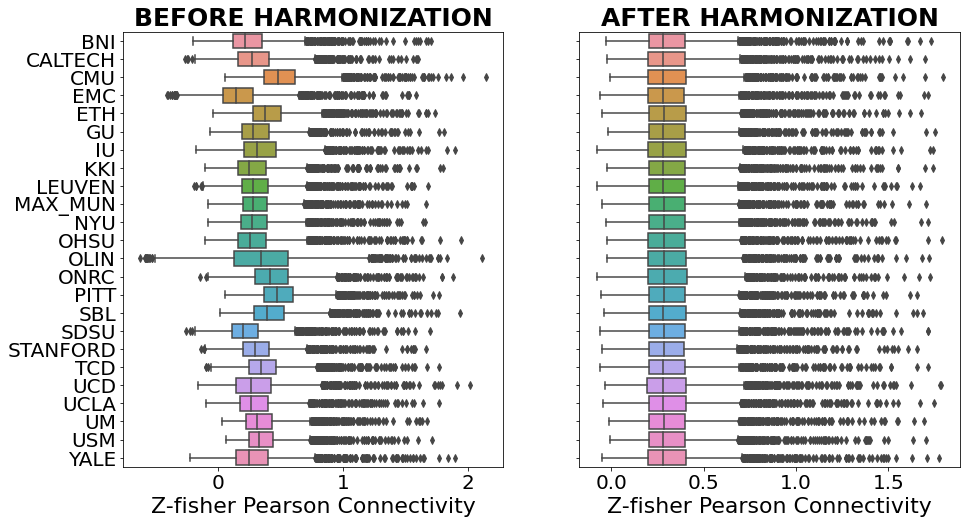

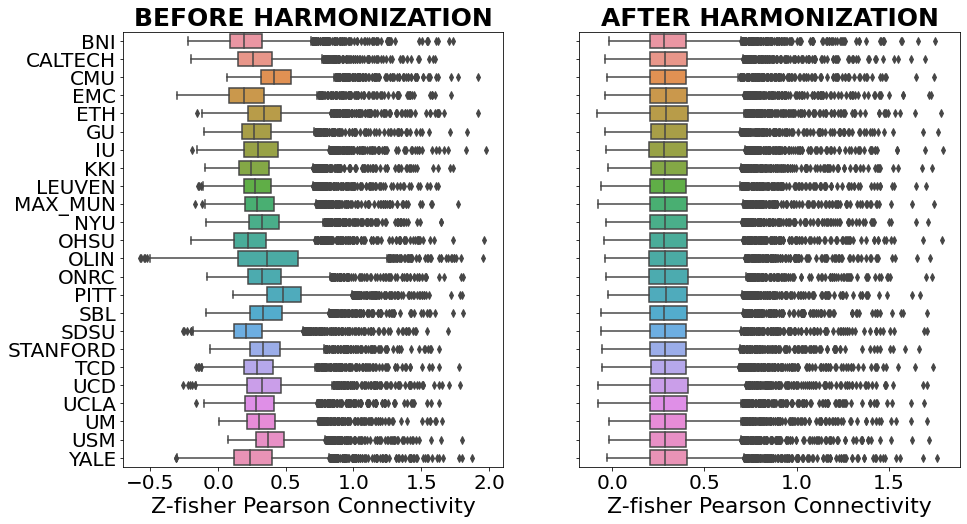

In [11]:
def harm_plot(Y, Y_combat, site):
    fig, axs = plt.subplots(figsize=(15, 8), ncols=2, sharey=True)
    
    site_uniques = np.unique(site)
    sns.boxplot(data=[Y[site==name,:].mean(axis=0).T for name in site_uniques], 
                ax=axs[0], showfliers=True, orient='horizontal')
    axs[0].set_yticklabels(site_uniques, rotation=0, size=20)
    axs[0].set_xlabel("Z-fisher Pearson Connectivity", size=22)
    axs[0].set_ylabel("")
    axs[0].set_title("BEFORE HARMONIZATION", size=25, weight='bold')
    axs[0].tick_params(labelsize=20)
    sns.boxplot(data=[Y_combat[site==name,:].mean(axis=0).T for name in site_uniques], 
                showfliers=True, orient='horizontal')
    axs[1].set_yticklabels(site_uniques, rotation=0)
    axs[1].set_xlabel("Z-fisher Pearson Connectivity", size=22)
    axs[1].set_title("AFTER HARMONIZATION", size=25, weight='bold')
    axs[1].tick_params(labelsize=20)
    pass

harm_plot(Y_1, Y_combat_1, site = site[idxs_1])
harm_plot(Y_2, Y_combat_2, site = site[idxs_2])

## 3- Denoise ASD in both halves

In [12]:
def denoise_asd(Y, C):
    from sklearn.linear_model import LinearRegression
    linReg = LinearRegression()
    linReg.fit(C, Y)
    Y_denoised = Y - C.dot(linReg.coef_.T)
    return Y_denoised

In [13]:
Y_combat_asd_1 = Y_combat_1[np.squeeze(group_1)==1]
C_1 = np.column_stack((sex_1, age_1, fd_1, dvars_1)) # Covariate effects
C_1 = C_1[np.squeeze(group_1)==1]
Y_combat_asd_denoised_1 = denoise_asd(Y_combat_asd_1, C_1)

Y_combat_asd_2 = Y_combat_2[np.squeeze(group_2)==1]
C_2 = np.column_stack((sex_2, age_2, fd_2, dvars_2)) # Covariate effects
C_2 = C_2[np.squeeze(group_2)==1]
Y_combat_asd_denoised_2 = denoise_asd(Y_combat_asd_2, C_2)

Check that this worked by computing the maximum correlations between denoised data and covariates

In [14]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
print("maximum correlation between FC data in half 1 and covariates: ", 
      np.abs(np.matmul(ss.fit_transform(Y_combat_asd_denoised_1).T, ss.fit_transform(C_1))).max()
     )
print("maximum correlation between FC data in half 2 and covariates: ", 
      np.abs(np.matmul(ss.fit_transform(Y_combat_asd_denoised_2).T, ss.fit_transform(C_2))).max()
     )

maximum correlation between FC data in half 1 and covariates:  3.4363251250916177e-12
maximum correlation between FC data in half 2 and covariates:  3.5702323045623146e-12


## 4 - Build (square) correlation matrices for subtyping...

In [15]:
CC_combat_asd_denoised_1 = np.array([squareform(Y_combat_asd_denoised_1[ii, :]) + np.identity(n_rois) \
                                     for ii in range(Y_combat_asd_denoised_1.shape[0])])
CC_combat_asd_denoised_2 = np.array([squareform(Y_combat_asd_denoised_2[ii, :]) + np.identity(n_rois) \
                                     for ii in range(Y_combat_asd_denoised_2.shape[0])])

## 5- Save for subtyping 

In [17]:
# Save data for later
np.savez(opj(results_dir,'data_after_combat_subset_1.npz'), 
         subjects=np.squeeze(subjects_1),
         age = np.squeeze(age_1), 
         sex=np.squeeze(sex_1), 
         site=np.squeeze(site_1), 
         group=np.squeeze(group_1), 
         Y_combat = Y_combat_1, 
         motion = motion_1,
         CC_combat_asd_denoised = CC_combat_asd_denoised_1)

savemat(opj(results_dir,'data_after_combat_subset_1.mat'), 
         {"subjects":np.squeeze(subjects_1),
          "age" : np.squeeze(age_1), 
          "sex":np.squeeze(sex_1), 
          "site":np.squeeze(site_1), 
          "group":np.squeeze(group_1), 
          "Y_combat":Y_combat_1, 
          "motion" : motion_1,
         "CC_combat_asd_denoised" : CC_combat_asd_denoised_1})

np.savez(opj(data_dir,'data_after_combat_82regs_motion_aggressive_My21_subset_2.npz'), 
         subjects=np.squeeze(subjects_2),
         age = np.squeeze(age_2), 
         sex=np.squeeze(sex_2), 
         site=np.squeeze(site_2), 
         group=np.squeeze(group_2), 
         Y_combat = Y_combat_2, 
         motion = motion_2,
         CC_combat_asd_denoised = CC_combat_asd_denoised_2)

savemat(opj(data_dir,'data_after_combat_82regs_motion_aggressive_My21_subset_2.mat'), 
         {"subjects":np.squeeze(subjects_2),
          "age" : np.squeeze(age_2), 
          "sex":np.squeeze(sex_2), 
          "site":np.squeeze(site_2), 
          "group":np.squeeze(group_2), 
          "Y_combat":Y_combat_2, 
          "motion" : motion_2,
         "CC_combat_asd_denoised" : CC_combat_asd_denoised_2})

In [18]:
# Save this also for clustering
savemat(opj(data_dir,'cors_combat_motion_aggressive_subset_1.mat'), 
        {'CC_combat_asd_denoised': CC_combat_asd_denoised_1})

savemat(opj(data_dir,'cors_combat_motion_aggressive_subset_2.mat'), 
        {'CC_combat_asd_denoised': CC_combat_asd_denoised_2})

# ... After running  subtyping in both halves...

## 6-Load clustering info 

In [20]:
# Same function as in notebook 3 to name the subtypes
def return_subject_clusters(S, subjects, threshold = 20):

    cluster_id, cluster_counts = np.unique(S, return_counts=True)
    cluster_order = cluster_id[np.argsort(cluster_counts)[::-1]]
    
    clus_idxs = [np.where(S==ii)[0] for ii in cluster_order]
    
    clus_subj = [subjects[idxs] for idxs in clus_idxs]
    
    cluster_labels = [[ii+1]*len(subjects) if len(subjects) > threshold else ['outlier']*len(subjects) \
                     for ii, subjects in enumerate(clus_subj)]
    
    return {'clus_subj': clus_subj, 'cluster_labels': cluster_labels}

In [24]:
case = 'res_cluster_euclidean'

# results from running subtyping in the first half
cons_res_1=loadmat(opj(results_dir, 'results_clustering_motion_aggressive_subset_1.mat'), 
                                struct_as_record=False, 
                                squeeze_me=True)[case]

S_euclidean_1 = cons_res_1.S
C_euclidean_1 = cons_res_1.C
subjects_clusters_euclidean_1 = return_subject_clusters(S_euclidean_1, 
                                                        subjects[idxs_1][np.squeeze(group_1)==1])

# results from running subtyping in the second half
cons_res_2=loadmat(opj(results_dir, 'results_clustering_motion_aggressive_subset_2.mat'), 
                                struct_as_record=False, 
                                squeeze_me=True)[case]

S_euclidean_2 = cons_res_2.S
C_euclidean_2 = cons_res_2.C
subjects_clusters_euclidean_2 = return_subject_clusters(S_euclidean_2,
                                                       subjects[idxs_2][np.squeeze(group_2)==1])

Content of subtyping  in first half:

In [25]:
np.unique(cons_res_1.S, return_counts=True)

(array([1, 2], dtype=uint8), array([189, 139]))

Two ASD subtypes of 189 and 139 subjects respectively

Content of subtyping  in second half:

In [26]:
np.unique(cons_res_2.S, return_counts=True)

(array([1, 2, 3, 4], dtype=uint8), array([142, 179,   7,   1]))

Two major ASD subtypes of 142 and 179 subjects respectively, with some outliers (7 and 1)

# Therefore, we can see that both halves mainly give two major subtypes, like when we were using the full dataset

Thus, if we computed the overall connectivity between subtypes in  both halves, we should find that one is hypo and the other hiper connectivity, as in the full case.

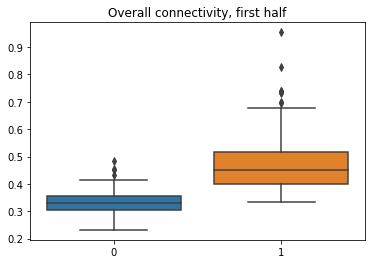

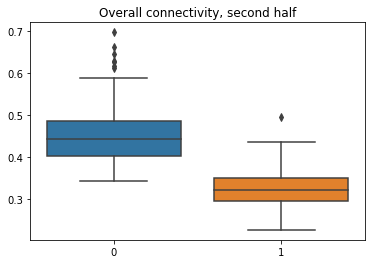

In [27]:
plt.figure()
sns.boxplot(data=[[np.mean(x[x>0]) for x in Y_combat_asd_1[cons_res_1.S==1]],
                  [np.mean(x[x>0]) for x in Y_combat_asd_1[cons_res_1.S==2]]])
plt.title("Overall connectivity, first half")

plt.figure()
sns.boxplot(data=[[np.mean(x[x>0]) for x in Y_combat_asd_2[cons_res_2.S==1]],
                  [np.mean(x[x>0]) for x in Y_combat_asd_2[cons_res_2.S==2]]])
plt.title("Overall connectivity, second half")
pass

So as we can see, the two major subtypes in both halves are again hypo and hiper respectively. They received a flipped label from GenLouvain (1 and 2 vs 2 and 1), but these names are arbitrary.

## 7- Run tests

In [28]:
demo_1 = pd.merge(pd.DataFrame({'SUB_ID': subjects[idxs_1]}), demo_merged, on='SUB_ID')
demo_2 = pd.merge(pd.DataFrame({'SUB_ID': subjects[idxs_2]}), demo_merged, on='SUB_ID')

demo_1['clus_id_euclidean'] = pd.NA
demo_2['clus_id_euclidean'] = pd.NA

demo_1.loc[demo_1.SUB_ID.isin(subjects[idxs_1][np.squeeze(group_1)==0]), 'clus_id_euclidean'] = 0
demo_2.loc[demo_2.SUB_ID.isin(subjects[idxs_2][np.squeeze(group_2)==0]), 'clus_id_euclidean'] = 0

for sub_clus, clus_label in zip(subjects_clusters_euclidean_1['clus_subj'], 
                                subjects_clusters_euclidean_1['cluster_labels']):
    demo_1.loc[demo_1.SUB_ID.isin(sub_clus), 'clus_id_euclidean'] = clus_label
    
for sub_clus, clus_label in zip(subjects_clusters_euclidean_2['clus_subj'], 
                                subjects_clusters_euclidean_2['cluster_labels']):
    demo_2.loc[demo_2.SUB_ID.isin(sub_clus), 'clus_id_euclidean'] = clus_label

In [29]:
demo_1.to_excel(opj(results_dir,'pheno_w_clusters_1.xlsx'), index=False)
demo_2.to_excel(opj(results_dir,'pheno_w_clusters_subset_2.xlsx'), index=False)

Are there any statistical difference in motion and age, which there should not be due to denoising?

In [30]:
print("First half:")
print(f_oneway(*[demo_1.loc[demo_1.clus_id_euclidean == clus_id,"FD_mean"].dropna() for clus_id in [1,2]]))
print(f_oneway(*[demo_1.loc[demo_1.clus_id_euclidean == clus_id,"DVARS_mean"].dropna() for clus_id in [1,2]]))
print(f_oneway(*[demo_1.loc[demo_1.clus_id_euclidean == clus_id,"AGE_AT_SCAN"].dropna() for clus_id in [1,2]]))

print("")
print("Second half:")
print(f_oneway(*[demo_2.loc[demo_2.clus_id_euclidean == clus_id,"FD_mean"].dropna() for clus_id in [1,2]]))
print(f_oneway(*[demo_2.loc[demo_2.clus_id_euclidean == clus_id,"DVARS_mean"].dropna() for clus_id in [1,2]]))
print(f_oneway(*[demo_2.loc[demo_2.clus_id_euclidean == clus_id,"AGE_AT_SCAN"].dropna() for clus_id in [1,2]]))

First half:
F_onewayResult(statistic=2.394437445706811, pvalue=0.122737738907547)
F_onewayResult(statistic=0.5677175694077253, pvalue=0.4517111358002164)
F_onewayResult(statistic=0.13339746542129638, pvalue=0.7151719608450997)

Second half:
F_onewayResult(statistic=0.0892502121901536, pvalue=0.7653270455171044)
F_onewayResult(statistic=0.07142459855625768, pvalue=0.7894464455731132)
F_onewayResult(statistic=0.7183817689036978, pvalue=0.39731069662759866)


## 8- Betwen-halves label classifcation

Given that we know that one subtype is hiper and the other hypo in both halves, define labels of each subtype as such and perform a classification, using one of  the halves as training set, and the other as testing. If both halves represent roughly the same, they should give high accuracy performances 

In [31]:
X_cpm_1 = Y_combat_asd_1[cons_res_1.S<3,:]
y_cpm_1 = ["hypo" if x==1 else "hiper" for x in cons_res_1.S[cons_res_1.S<3]]
y_cpm_1 = LabelEncoder().fit_transform(y_cpm_1)

X_cpm_2 = Y_combat_asd_2[cons_res_2.S<3,:]

y_cpm_2 = ["hypo" if x==2 else "hiper" for x in cons_res_2.S[cons_res_2.S<3]]
y_cpm_2 = LabelEncoder().fit_transform(y_cpm_2)
y_cmp_2 = (y_cpm_2==0).astype(int)

In [32]:
from my_sklearn_tools.cpm import CPMClassification
from sklearn.metrics import rand_score, balanced_accuracy_score

cpm = CPMClassification()

cpm.fit(X_cpm_1, y_cpm_1)
y_cpm_2_pred = cpm.predict(X_cpm_2)
print("Predict labels in the second half, training on the first one")
print("ACC: ", balanced_accuracy_score(y_cpm_2, y_cpm_2_pred))
print("Rand index: ", rand_score(y_cpm_2, y_cpm_2_pred))

print(" ")

cpm.fit(X_cpm_2, y_cpm_2)
y_cpm_1_pred = cpm.predict(X_cpm_1)
print("Predict labels in the first half, training on the second one")
print("ACC: ", balanced_accuracy_score(y_cpm_1, y_cpm_1_pred))
print("Rand index: ", rand_score(y_cpm_1, y_cpm_1_pred))


Predict labels in the second half, training on the first one
ACC:  0.934062475411126
Rand index:  0.8773364485981309
 
Predict labels in the first half, training on the second one
ACC:  0.9332343648890411
Rand index:  0.8744685611993734


We see that each half is able to classify well the subtypes of the other half. Therefore, we conclude that they give rise to similar subtype solutions